In [1]:
import numpy as np
from qiskit import BasicAer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import IBMQ
provider = IBMQ.load_account()
from collections import OrderedDict
from operator import itemgetter
IBMQ.providers()


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>,
 <AccountProvider for IBMQ(hub='q-summer-school', group='main', project='project-2')>]

In [2]:
# provider = IBMQ.load_account()
# provider.backends()

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='qamp', project='fall-22-29')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-29')>,
 <IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q-community', group='qamp', project='fall-22-2

In [4]:
def misere_step(ones,piles):
    # even number of piles of 1 eg (1,1,3,0) or (0,0,3,0)
    if ones%2 == 0:
        objects_to_remove = []
        removable_amount = 1
        for i in range(len(piles)):
            if piles[i] > 1:
                objects_to_remove.append(piles[i]-1)
            else:
                objects_to_remove.append(0)
    # odd number of piles of 1 eg (1,1,3,1)
    else:
        objects_to_remove = []
        removable_amount = 1
        for i in range(len(piles)):
            if piles[i] > 1:
                objects_to_remove.append(piles[i])
            else:
                objects_to_remove.append(0)
    return objects_to_remove, removable_amount

def get_piles_to_remove(piles):
    nim_sum = 0
    for p in piles:
        nim_sum = nim_sum ^ p
    objects_to_remove = []
    removable_amount = 0
    for p in piles:
        new_p = p^nim_sum
        if new_p < p:
            objects_to_remove.append(p-new_p)
            removable_amount = removable_amount + 1
        else:
            objects_to_remove.append(0)
    return objects_to_remove, removable_amount


In [5]:
def custom_qft(data_qubits):
    qr_data = QuantumRegister(data_qubits)
    qc = QuantumCircuit(qr_data)
    i = data_qubits
    while i>=1:
        n = i - 1
        qc.h(qr_data[n]) 
        for qubit in range(n):
            qc.cp(np.pi/2**(n-qubit), qr_data[qubit], qr_data[n])
        i = i-1
    return qc

def subroutine_add_const(data_qubits: int, const: int, to_gate=True):
    qc = QuantumCircuit(data_qubits)
    for i in range(data_qubits):
        angle = const*np.pi/(2**i)
        qc.p(angle,i)
    return qc.to_gate(label=" ["+str(const)+"] ") if to_gate else qc

In [6]:
def diffusion_operation(qc, address, flag, removable_pile):
    def nim_oracle(qc,address,flag,removable_pile):

        # 0001 -> 001
        if removable_pile[0] != 0:
            print("Removable Pile 0")
            qc.x(address[1])
            qc.x(address[2])
            qc.mct(address[:],flag)
            qc.x(address[2])
            qc.x(address[1])
        
        # 0010 -> 010
        if removable_pile[1] != 0:
            print("Removable Pile 1")
            qc.x(address[0])
            qc.x(address[2])
            qc.mct(address[:],flag)
            qc.x(address[2])
            qc.x(address[0])
    
        # 0100 -> 011
        if removable_pile[2] != 0:
            print("Removable Pile 2")
            qc.x(address[2])
            qc.mct(address[:],flag)
            qc.x(address[2])
        
        # 1000 -> 100
        if removable_pile[3] != 0:
            print("Removable Pile 3")
            qc.x(address[0])
            qc.x(address[1])
            qc.mct(address[:],flag)
            qc.x(address[1])
            qc.x(address[0])


    qc.x(flag)
    qc.h(flag)

    qc.h(address[:])
    nim_oracle(qc,address,flag,removable_pile)
    qc.h(address[:])
    qc.x(address[:])
    qc.h(address[2])
    qc.mct(address[0:2], address[2])
    qc.h(address[2])
    qc.x(address[:])
    qc.h(address[:])
    

In [7]:
def qc_process(qc,objects_to_remove,address,removable_pile,removable_count):
    
    if removable_count == 0:
        for i in range(len(removable_pile)):
            removable_pile[i] = 1
        removable_count = 4

    if removable_count == 4:
        removable_pile[removable_pile.index(min(removable_pile))] = 0
        removable_count = removable_count - 1
    
    qft_gate = custom_qft(3).to_gate()
    inverse_qft_gate = custom_qft(3).inverse().to_gate()

    if removable_count == 1:
        qc.swap(objects_to_remove[0],objects_to_remove[2])
        qc.append(qft_gate,objects_to_remove[:])
        # 0001 -> 001
        if removable_pile[0] != 0:
            add_gate = subroutine_add_const(3,removable_pile[0])
            qc.x(address[0])
        # 0010 -> 010
        elif removable_pile[1] != 0:
            add_gate = subroutine_add_const(3,removable_pile[1])
            qc.x(address[1])
        # 0100 -> 011
        elif removable_pile[2] != 0:
            add_gate = subroutine_add_const(3,removable_pile[2])
            qc.x(address[0])
            qc.x(address[1])
        # 1000 -> 100
        elif removable_pile[3] != 0:
            add_gate = subroutine_add_const(3,removable_pile[3])
            qc.x(address[2])

        qc.append(add_gate,objects_to_remove[:])
        qc.append(inverse_qft_gate,objects_to_remove[:])
        qc.swap(objects_to_remove[0],objects_to_remove[2])

    else:
        diffusion_operation(qc,address, flag, removable_pile)
        qc.swap(objects_to_remove[0],objects_to_remove[2])
        qc.append(qft_gate,objects_to_remove[:])
        for i,remove_amount in enumerate(removable_pile):
            if remove_amount != 0:

                bin_i = list(bin(i+1)[2:])
                while len(bin_i) != 3:
                    bin_i.insert(0,'0')
                bin_i = bin_i[::-1]
                for j in range(len(bin_i)):
                    if bin_i[j] == '0':
                        qc.x(address[j])

                controlled_add_gate = subroutine_add_const(3,remove_amount).control(3)    
                qc.append(controlled_add_gate,address[:]+objects_to_remove[:])

                for j in range(len(bin_i)):
                    if bin_i[j] == '0':
                        qc.x(address[j])

        qc.append(inverse_qft_gate,objects_to_remove[:])
        qc.swap(objects_to_remove[0],objects_to_remove[2])

In [8]:
## check misere_step

# piles = [1,3,4,5]
piles = [1,2,6,7]
# piles = [6,6,7,6]
# piles = [1,3,4,7]
# piles = [0,0,7,7]
# piles = [1,3,2,0]
# piles = [1,2,4,7]
# piles = [1,0,0,4]

ones = piles.count(1)
zeros = piles.count(0)
non_zeros = 4 - (ones+zeros)

# all zeros except one eg (0,0,0,7) OR some zeros some ones some non_zeros
# leave odd piles of 1s
if non_zeros == 1: 
    removable_pile, removable_count = misere_step(ones, piles) 
else:
    removable_pile, removable_count = get_piles_to_remove(piles)
print(removable_pile, removable_count)

objects_to_remove = QuantumRegister(3,'piles')
flag = QuantumRegister(1,'flag')
output_piles = ClassicalRegister(3,'final_piles')
address = QuantumRegister(3,'address')
pick_pile = ClassicalRegister(3,'choose_pile')
qc = QuantumCircuit(objects_to_remove,address,flag,output_piles,pick_pile)
qc_process(qc,objects_to_remove,address,removable_pile,removable_count)




[0, 2, 2, 2] 3
Removable Pile 1
Removable Pile 2
Removable Pile 3


In [9]:
qc.measure(address[:],pick_pile[:])
qc.measure(objects_to_remove[:],output_piles[:])


In [10]:
backend = BasicAer.get_backend('qasm_simulator')
# backend = provider.backends.ibmq_qasm_simulator
# backend = provider.get_backend('ibm_nairobi')
job = execute(qc,backend,shots=1024)
result = job.result()
counts = result.get_counts()
qc_move = (counts.most_frequent())
counts

{'011 010': 302,
 '010 010': 272,
 '100 010': 298,
 '001 000': 31,
 '111 000': 32,
 '101 000': 23,
 '110 000': 32,
 '000 000': 34}

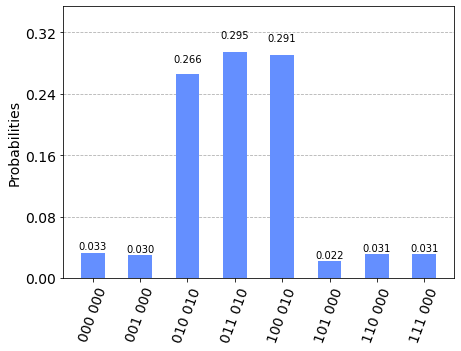

In [11]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [12]:
backend = provider.backends.ibmq_qasm_simulator
job = execute(qc,backend,shots=1024)
result = job.result()
counts = result.get_counts()
counts = OrderedDict(sorted(counts.items(), key=itemgetter(1), reverse=True)) # sort by counts
print(counts)
counts

<ipython-input-12-25bb87d63097>:1: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  backend = provider.backends.ibmq_qasm_simulator


OrderedDict([('100 010', 297), ('011 010', 282), ('010 010', 280), ('110 000', 43), ('000 000', 37), ('001 000', 32), ('111 000', 27), ('101 000', 26)])


OrderedDict([('100 010', 297),
             ('011 010', 282),
             ('010 010', 280),
             ('110 000', 43),
             ('000 000', 37),
             ('001 000', 32),
             ('111 000', 27),
             ('101 000', 26)])

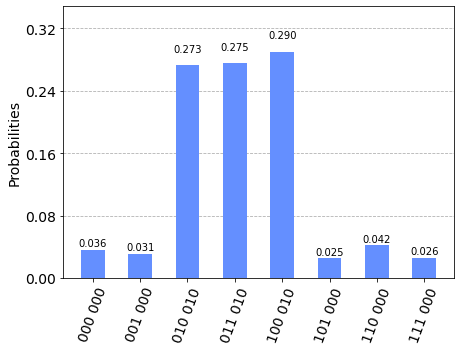

In [13]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [14]:
from qiskit.providers.aer import QasmSimulator
sim_noisy_nairobi = QasmSimulator.from_backend(provider.get_backend('ibm_nairobi'))
job = execute(qc,sim_noisy_nairobi,shots=1024)
result = job.result()
counts = result.get_counts()
# qc_move = (counts.most_frequent())
counts = OrderedDict(sorted(counts.items(), key=itemgetter(1), reverse=True)) # sort by counts
print(counts)
counts

OrderedDict([('101 000', 34), ('100 010', 33), ('010 000', 32), ('111 000', 29), ('000 000', 28), ('011 010', 28), ('011 000', 27), ('100 110', 26), ('100 000', 26), ('010 010', 24), ('110 000', 23), ('001 000', 23), ('001 001', 23), ('110 001', 22), ('000 010', 21), ('101 100', 20), ('010 001', 20), ('110 011', 19), ('011 100', 18), ('000 011', 18), ('011 001', 17), ('000 111', 17), ('101 010', 16), ('111 111', 16), ('100 100', 16), ('001 011', 16), ('001 110', 16), ('101 001', 16), ('110 010', 15), ('011 101', 15), ('110 100', 15), ('011 110', 15), ('101 011', 14), ('001 101', 14), ('010 011', 14), ('010 100', 14), ('000 001', 13), ('100 001', 13), ('001 010', 13), ('110 111', 13), ('111 100', 13), ('111 010', 13), ('100 011', 13), ('010 111', 12), ('001 100', 12), ('000 100', 12), ('100 111', 11), ('111 101', 11), ('101 101', 11), ('011 011', 11), ('101 111', 10), ('100 101', 10), ('010 110', 10), ('101 110', 9), ('110 110', 8), ('110 101', 8), ('001 111', 8), ('111 011', 8), ('011 

OrderedDict([('101 000', 34),
             ('100 010', 33),
             ('010 000', 32),
             ('111 000', 29),
             ('000 000', 28),
             ('011 010', 28),
             ('011 000', 27),
             ('100 110', 26),
             ('100 000', 26),
             ('010 010', 24),
             ('110 000', 23),
             ('001 000', 23),
             ('001 001', 23),
             ('110 001', 22),
             ('000 010', 21),
             ('101 100', 20),
             ('010 001', 20),
             ('110 011', 19),
             ('011 100', 18),
             ('000 011', 18),
             ('011 001', 17),
             ('000 111', 17),
             ('101 010', 16),
             ('111 111', 16),
             ('100 100', 16),
             ('001 011', 16),
             ('001 110', 16),
             ('101 001', 16),
             ('110 010', 15),
             ('011 101', 15),
             ('110 100', 15),
             ('011 110', 15),
             ('101 011', 14),
          

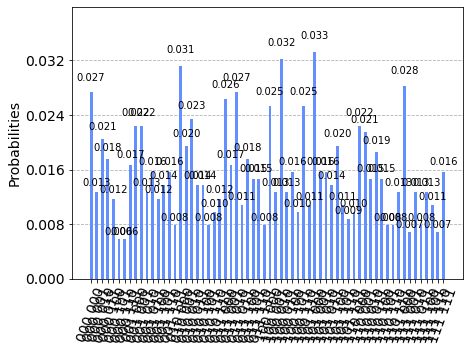

In [15]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [16]:
from qiskit.providers.aer import QasmSimulator
sim_noisy_oslo = QasmSimulator.from_backend(provider.get_backend('ibm_oslo'))
job = execute(qc,sim_noisy_oslo,shots=1024)
result = job.result()
counts = result.get_counts()
# qc_move = (counts.most_frequent())
counts = OrderedDict(sorted(counts.items(), key=itemgetter(1), reverse=True)) # sort by count
print(counts)
counts

OrderedDict([('100 010', 69), ('011 010', 41), ('111 000', 35), ('110 000', 33), ('101 000', 32), ('100 011', 31), ('010 010', 31), ('001 000', 30), ('011 011', 28), ('000 000', 28), ('100 000', 27), ('100 110', 23), ('010 000', 23), ('000 010', 20), ('001 010', 20), ('011 000', 19), ('110 010', 18), ('010 001', 18), ('101 011', 17), ('011 001', 17), ('100 001', 17), ('011 110', 16), ('010 011', 16), ('101 111', 16), ('101 010', 16), ('101 100', 15), ('001 011', 14), ('111 010', 14), ('000 001', 14), ('101 001', 14), ('011 100', 14), ('010 111', 14), ('111 011', 13), ('000 100', 12), ('000 111', 12), ('000 101', 12), ('010 100', 12), ('000 110', 11), ('001 001', 11), ('000 011', 11), ('100 111', 11), ('110 011', 10), ('111 100', 10), ('100 101', 10), ('110 111', 10), ('010 110', 10), ('011 111', 10), ('100 100', 9), ('101 110', 9), ('001 111', 8), ('110 001', 8), ('001 100', 8), ('010 101', 8), ('111 111', 8), ('110 100', 8), ('111 001', 8), ('111 110', 7), ('001 110', 7), ('101 101', 

OrderedDict([('100 010', 69),
             ('011 010', 41),
             ('111 000', 35),
             ('110 000', 33),
             ('101 000', 32),
             ('100 011', 31),
             ('010 010', 31),
             ('001 000', 30),
             ('011 011', 28),
             ('000 000', 28),
             ('100 000', 27),
             ('100 110', 23),
             ('010 000', 23),
             ('000 010', 20),
             ('001 010', 20),
             ('011 000', 19),
             ('110 010', 18),
             ('010 001', 18),
             ('101 011', 17),
             ('011 001', 17),
             ('100 001', 17),
             ('011 110', 16),
             ('010 011', 16),
             ('101 111', 16),
             ('101 010', 16),
             ('101 100', 15),
             ('001 011', 14),
             ('111 010', 14),
             ('000 001', 14),
             ('101 001', 14),
             ('011 100', 14),
             ('010 111', 14),
             ('111 011', 13),
          

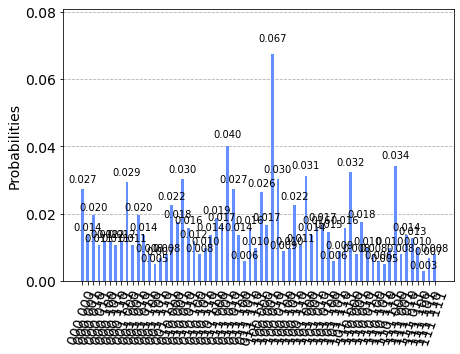

In [17]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

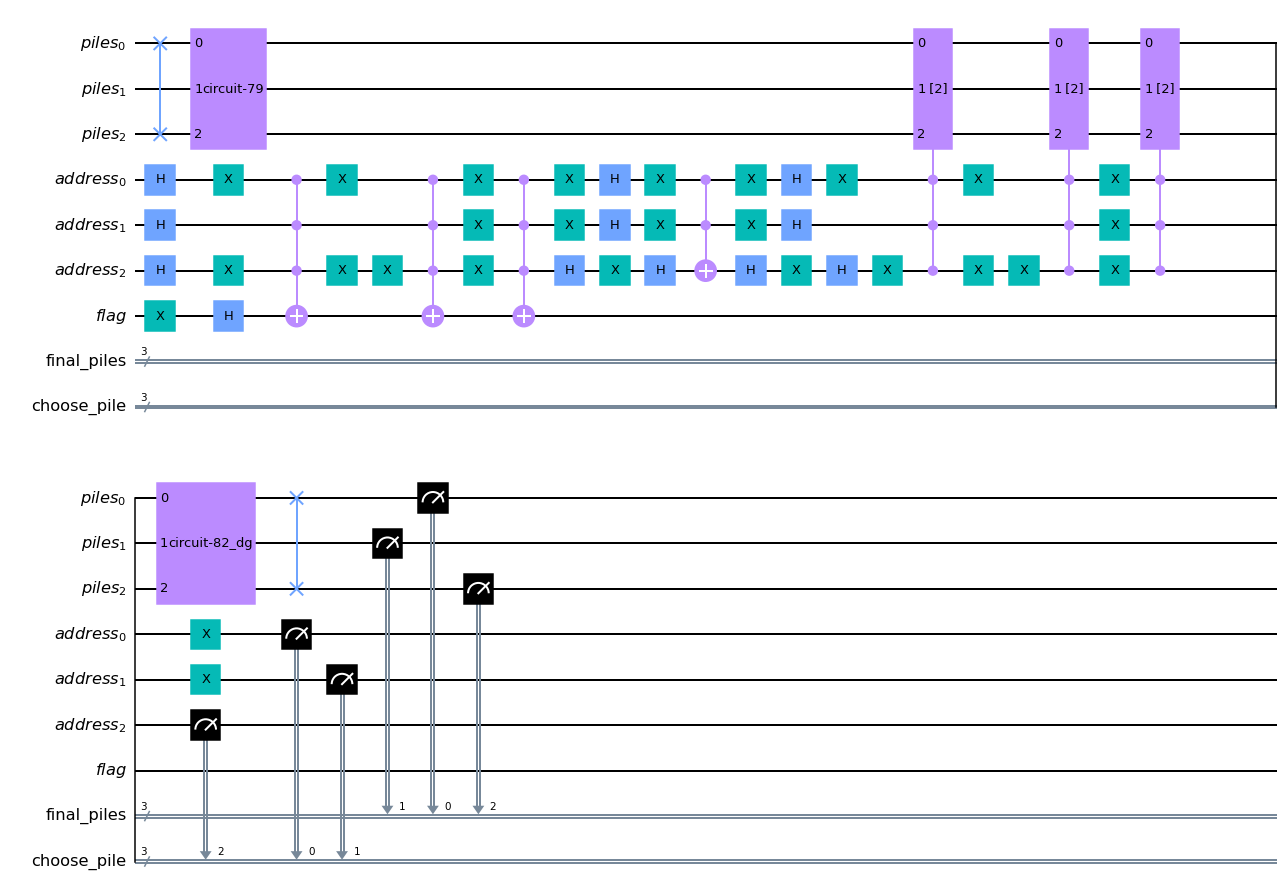

In [18]:
qc.draw(output='mpl')

In [19]:
board_choice = qc_move.split(' ')[0]
# board_choice = board_choice[::-1]

print(board_choice)
board_choice = int(board_choice,2)

print("Pick from:",board_choice)
board_state = qc_move.split(' ')[1]


board_state = board_state[::-1]
amount = int(board_state,2)
print("Amount:", amount)

011
Pick from: 3
Amount: 2
